In [1]:
import pandas as pd
import numpy as np
import ast
import pickle
from pathlib import Path
import matplotlib.pyplot as plt
import spikeanal as spike
from matplotlib_venn import venn2
from matplotlib_venn import venn3

cols = ['condition ', 'session_dir', 'all_subjects', 'tone_start_timestamp', 'tone_stop_timestamp']

# Load the data
df = pd.read_excel('rce_pilot_2_per_video_trial_labels.xlsx', usecols=cols, engine='openpyxl')

df2 = df.dropna() # Drop the rows missing data
df3 = df2.copy()
df3['all_subjects'] = df3['all_subjects'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x) # Make the 'all_subjects' column readable as a list
df4 = df3[df3['all_subjects'].apply(lambda x: len(x) < 3)] # Ignore novel sessions for now

# Initialize an empty list to collect data for the new DataFrame
new_df_data = []

for _, row in df4.iterrows():
    session_dir = row['session_dir']
    subjects = row['all_subjects']
    condition = row['condition ']

    # Split session_dir on '_subj_' and take the first part only
    # This ensures everything after '_subj_' is ignored
    base_session_dir = session_dir.split('_subj_')[0]

    for subject in subjects:
        subject_formatted = subject.replace('.', '-')
        # Append formatted subject to the base session_dir correctly
        subj_recording = f"{base_session_dir}_subj_{subject_formatted}"
        new_df_data.append({
            'session_dir': session_dir,
            'subject': subject,
            'subj_recording': subj_recording,
            'condition': condition if condition in ['rewarded', 'omission', 'both_rewarded', 'tie'] else ('win' if str(condition) == str(subject) else 'lose'),
            'tone_start_timestamp': row['tone_start_timestamp'],
            'tone_stop_timestamp': row['tone_stop_timestamp']
        })

# Convert list to DataFrame
new_df = pd.DataFrame(new_df_data)
new_df = new_df.drop_duplicates()

# Prepare timestamp_dicts from new_df
timestamp_dicts = {}
for _, row in new_df.iterrows():
    key = row['subj_recording']
    condition = row['condition']
    timestamp_start = int(row['tone_start_timestamp']) // 20
    timestamp_end = int(row['tone_stop_timestamp']) // 20
    tuple_val = (timestamp_start, timestamp_end)

    if key not in timestamp_dicts:
        timestamp_dicts[key] = {cond: [] for cond in ['rewarded', 'win', 'lose', 'omission', 'both_rewarded', 'tie']}
    timestamp_dicts[key][condition].append(tuple_val)

# Convert lists in timestamp_dicts to numpy arrays
for subj_recording in timestamp_dicts:
    for condition in timestamp_dicts[subj_recording]:
        timestamp_dicts[subj_recording][condition] = np.array(timestamp_dicts[subj_recording][condition], dtype=np.int64)
        

# Construct the path in a platform-independent way (HiPerGator or Windows)
ephys_path = Path('.') / 'export' / 'updated_phys' / 'non-novel' / 'both_rewarded'

ephys_data = spike.EphysRecordingCollection(str(ephys_path))

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
Unit 92 is unsorted & has 2494 spikes
Unit 92 will be deleted
20230622_110832_standard_comp_to_both_rewarded_D1_subj_1-1_t1b3L_box1_merged.rec
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
Unit 103 is unsorted & has 512 spikes
Unit 103 will be deleted
20230622_110832_standard_comp_to_both_rewarded_D1_subj_1-2_t3b3L_box1_merged.rec
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
20230624_105855_standard_comp_to_both_rewarded_D3_subj_1-2_t1b2L_box1_merged.rec
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
20230624_105855_standard_comp_to_both_rewarded_D3_subj_1-4_t3b3L_box1_merged.rec
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
20230625_112913_standard_comp_to_both_rewarded_D4_subj_1-1_t1b2L_box1_merged.rec
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
Unit 96 is unsorted & has 5811 spikes
Unit 96 will be deleted
Unit 95 is unsorted & has 6458 spikes
Unit 95 will be deleted
20230625_112913_standard_comp_to_both_rewarded_D4_subj_1-4

In [2]:
for recording in ephys_data.collection.keys():
    # Check if the recording key (without everything after subject #) is in timestamp_dicts
    start_pos = recording.find('subj_')
    # Add the length of 'subj_' and 3 additional characters to include after 'subj_'
    end_pos = start_pos + len('subj_') + 3
    # Slice the recording key to get everything up to and including the subject identifier plus three characters
    recording_key_without_suffix = recording[:end_pos]
    if recording_key_without_suffix in timestamp_dicts:
        # Assign the corresponding timestamp_dicts dictionary to event_dict
        ephys_data.collection[recording].event_dict = timestamp_dicts[recording_key_without_suffix]
        
        # Extract the subject from the recording key
        start = recording.find('subj_') + 5  # Start index after 'subj_'
        subject = recording[start:start+3]
        
        # Assign the extracted subject
        ephys_data.collection[recording].subject = subject
        
spike_analysis = spike.SpikeAnalysis_MultiRecording(ephys_data, timebin = 5, smoothing_window=250, ignore_freq = 0.5)

All set to analyze


In [3]:
# Create df of spike freq 10s before and 10s during every event
event_spikes = spike_analysis.generate_event_dataframe()

# Identify 'Pre-event' and 'Event' columns
pre_event_cols = [col for col in event_spikes.columns if col.startswith('Pre-event')]
event_cols = [col for col in event_spikes.columns if col.startswith('Event') and col not in ['Event name', 'Event number']]

In [4]:
event_spikes

,Recording,Event name,Event number,Unit number,Pre-event timebin 1,Pre-event timebin 2,Pre-event timebin 3,Pre-event timebin 4,Pre-event timebin 5,Pre-event timebin 6,...,Event timebin 1991,Event timebin 1992,Event timebin 1993,Event timebin 1994,Event timebin 1995,Event timebin 1996,Event timebin 1997,Event timebin 1998,Event timebin 1999,Event timebin 2000
0,20230622_110832_standard_comp_to_both_rewarded...,lose,1,9,8.0,8.0,8.0,8.0,8.0,4.0,...,16.0,20.0,20.0,20.0,16.0,16.0,20.0,20.0,20.0,20.0
1,20230622_110832_standard_comp_to_both_rewarded...,lose,2,9,8.0,8.0,8.0,8.0,8.0,8.0,...,12.0,12.0,12.0,12.0,12.0,16.0,16.0,16.0,16.0,16.0
2,20230622_110832_standard_comp_to_both_rewarded...,lose,3,9,8.0,8.0,8.0,8.0,8.0,8.0,...,12.0,12.0,12.0,12.0,12.0,12.0,12.0,12.0,12.0,12.0
3,20230622_110832_standard_comp_to_both_rewarded...,lose,4,9,12.0,12.0,12.0,12.0,12.0,8.0,...,4.0,8.0,8.0,8.0,8.0,8.0,8.0,8.0,12.0,12.0
4,20230622_110832_standard_comp_to_both_rewarded...,lose,5,9,8.0,8.0,8.0,8.0,8.0,8.0,...,16.0,16.0,16.0,16.0,16.0,16.0,16.0,12.0,12.0,12.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4796,20230625_112913_standard_comp_to_both_rewarded...,both_rewarded,16,11,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4797,20230625_112913_standard_comp_to_both_rewarded...,both_rewarded,17,11,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4798,20230625_112913_standard_comp_to_both_rewarded...,both_rewarded,18,11,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4799,20230625_112913_standard_comp_to_both_rewarded...,both_rewarded,19,11,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


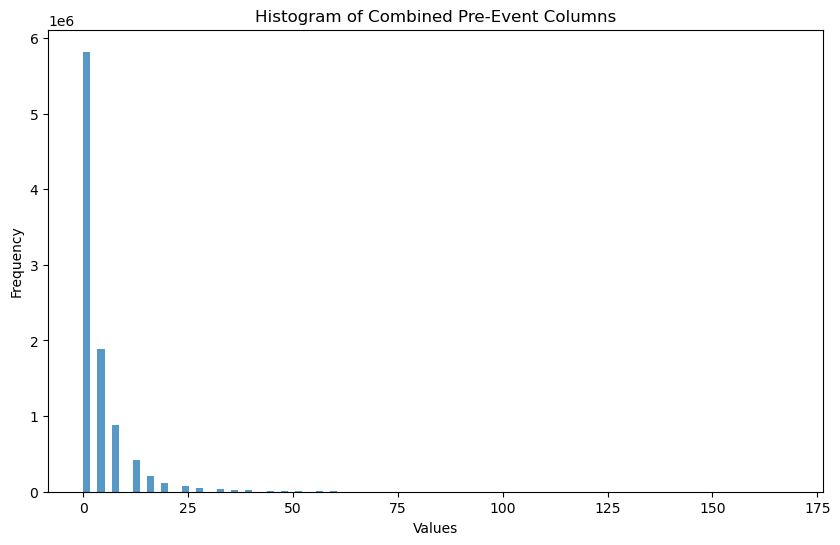

In [6]:
combined_values = event_spikes[pre_event_cols].values.flatten()

# Plot a histogram of the combined values
plt.figure(figsize=(10, 6))
plt.hist(combined_values, bins=100, alpha=0.75)
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.title('Histogram of Combined Pre-Event Columns')
plt.show()

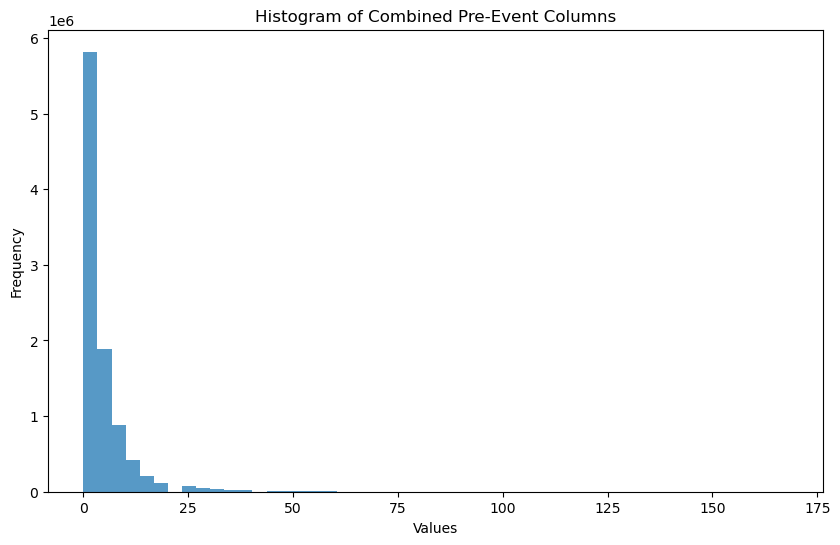

In [7]:
combined_values = event_spikes[pre_event_cols].values.flatten()

# Plot a histogram of the combined values
plt.figure(figsize=(10, 6))
plt.hist(combined_values, bins=50, alpha=0.75)
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.title('Histogram of Combined Pre-Event Columns')
plt.show()

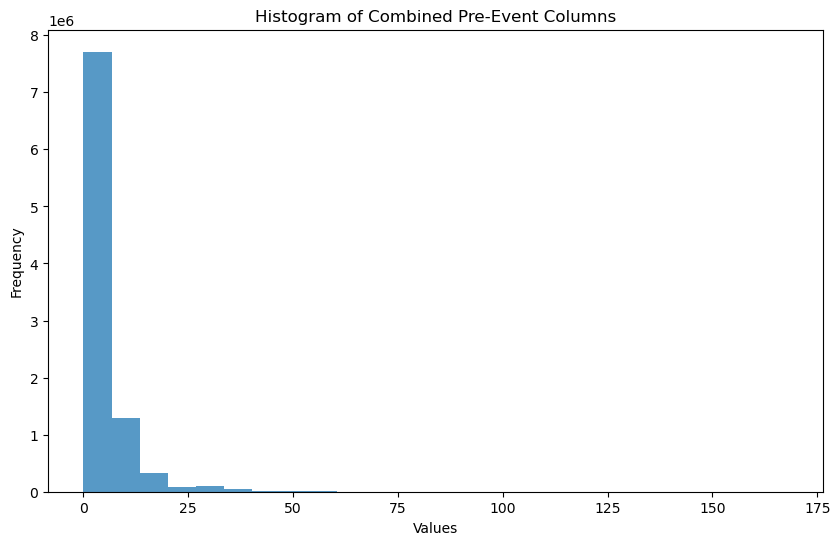

In [10]:
combined_values = event_spikes[pre_event_cols].values.flatten()

# Plot a histogram of the combined values
plt.figure(figsize=(10, 6))
plt.hist(combined_values, bins=25, alpha=0.75)
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.title('Histogram of Combined Pre-Event Columns')
plt.show()

In [13]:
event_spikes['Pre-event timebin 1'].value_counts()

Pre-event timebin 1
0.0      2911
4.0       905
8.0       465
12.0      190
16.0      129
20.0       62
24.0       34
28.0       25
32.0       22
36.0       14
40.0       13
48.0        6
52.0        6
44.0        5
56.0        4
60.0        3
80.0        1
136.0       1
84.0        1
64.0        1
76.0        1
96.0        1
92.0        1
Name: count, dtype: int64

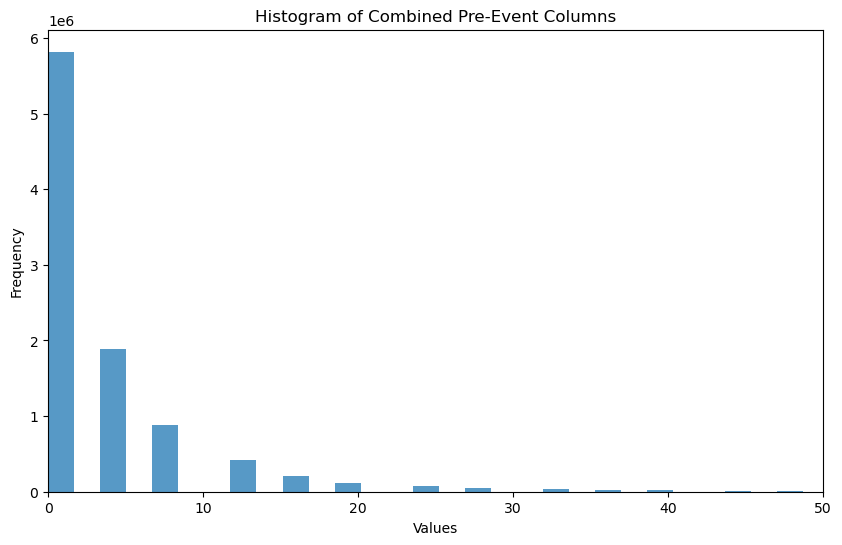

In [18]:
combined_values = event_spikes[pre_event_cols].values.flatten()

# Plot a histogram of the combined values
plt.figure(figsize=(10, 6))
plt.hist(combined_values, bins=100, alpha=0.75)
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.title('Histogram of Combined Pre-Event Columns')

# Set the x-axis limit
plt.xlim(0, 50)

plt.show()

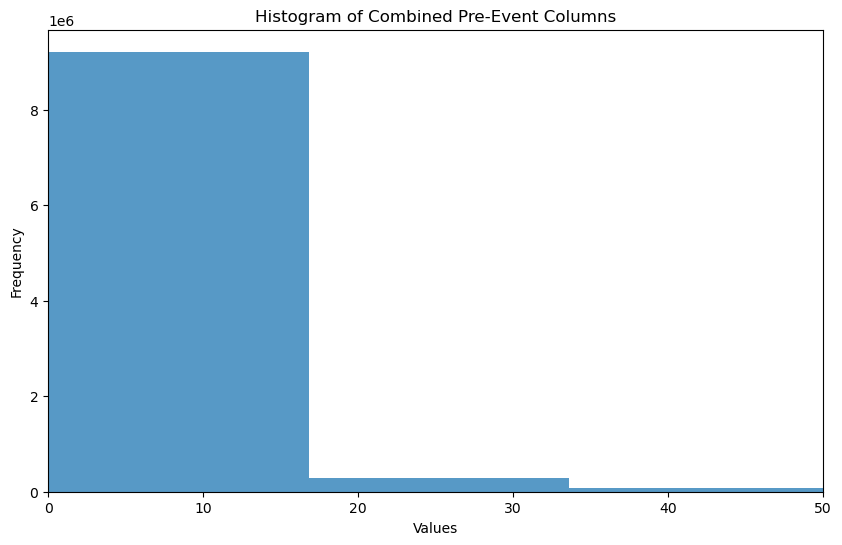

In [19]:
combined_values = event_spikes[pre_event_cols].values.flatten()

# Plot a histogram of the combined values
plt.figure(figsize=(10, 6))
plt.hist(combined_values, alpha=0.75)
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.title('Histogram of Combined Pre-Event Columns')

# Set the x-axis limit
plt.xlim(0, 50)

plt.show()

C:\Users\short\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


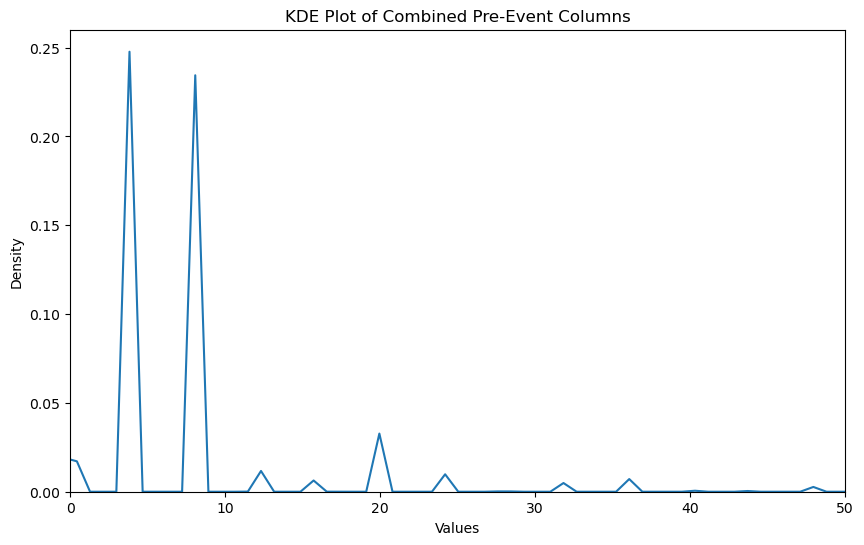

In [20]:
import seaborn as sns

# Assuming event_spikes is your DataFrame and it's already loaded
# Define the pre_event_cols
pre_event_cols = [col for col in event_spikes.columns if col.startswith('Pre-event')]

# Combine all values from pre_event_cols into a single series
combined_values = event_spikes[pre_event_cols].values.flatten()

# Plot KDE for the combined values
plt.figure(figsize=(10, 6))
sns.kdeplot(combined_values, bw_adjust=0.5)  # bw_adjust can be tuned for more or less smoothing
plt.xlabel('Values')
plt.ylabel('Density')
plt.title('KDE Plot of Combined Pre-Event Columns')

# Set the x-axis limit
plt.xlim(0, 50)

plt.show()

In [24]:
spike_analysis = spike.SpikeAnalysis_MultiRecording(ephys_data, timebin=100, smoothing_window=300, ignore_freq=0.5)

All set to analyze


In [25]:
# Create df of spike freq 10s before and 10s during every event
event_spikes = spike_analysis.generate_event_dataframe()

# Identify 'Pre-event' and 'Event' columns
pre_event_cols = [col for col in event_spikes.columns if col.startswith('Pre-event')]
event_cols = [col for col in event_spikes.columns if col.startswith('Event') and col not in ['Event name', 'Event number']]

In [26]:
event_spikes

,Recording,Event name,Event number,Unit number,Pre-event timebin 1,Pre-event timebin 2,Pre-event timebin 3,Pre-event timebin 4,Pre-event timebin 5,Pre-event timebin 6,...,Event timebin 91,Event timebin 92,Event timebin 93,Event timebin 94,Event timebin 95,Event timebin 96,Event timebin 97,Event timebin 98,Event timebin 99,Event timebin 100
0,20230622_110832_standard_comp_to_both_rewarded...,lose,1,9,10.000000,10.000000,10.000000,3.333333,6.666667,10.000000,...,16.666667,10.000000,6.666667,3.333333,6.666667,13.333333,10.000000,10.000000,10.000000,20.000000
1,20230622_110832_standard_comp_to_both_rewarded...,lose,2,9,6.666667,6.666667,16.666667,16.666667,23.333333,23.333333,...,6.666667,16.666667,20.000000,16.666667,10.000000,6.666667,6.666667,6.666667,10.000000,13.333333
2,20230622_110832_standard_comp_to_both_rewarded...,lose,3,9,10.000000,10.000000,20.000000,23.333333,23.333333,13.333333,...,20.000000,20.000000,6.666667,3.333333,10.000000,16.666667,23.333333,13.333333,10.000000,10.000000
3,20230622_110832_standard_comp_to_both_rewarded...,lose,4,9,10.000000,3.333333,6.666667,6.666667,16.666667,26.666667,...,6.666667,10.000000,10.000000,10.000000,13.333333,16.666667,16.666667,10.000000,3.333333,10.000000
4,20230622_110832_standard_comp_to_both_rewarded...,lose,5,9,13.333333,20.000000,23.333333,23.333333,36.666667,33.333333,...,10.000000,13.333333,16.666667,13.333333,13.333333,23.333333,23.333333,26.666667,13.333333,13.333333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4796,20230625_112913_standard_comp_to_both_rewarded...,both_rewarded,16,11,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4797,20230625_112913_standard_comp_to_both_rewarded...,both_rewarded,17,11,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4798,20230625_112913_standard_comp_to_both_rewarded...,both_rewarded,18,11,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4799,20230625_112913_standard_comp_to_both_rewarded...,both_rewarded,19,11,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,3.333333,3.333333,3.333333,0.000000,0.000000


In [28]:
recordings = spike_analysis.ephyscollection.collection

recording_name1 = '20230622_110832_standard_comp_to_both_rewarded_D1_subj_1-1_t1b3L_box1_merged.rec'
recording1 = recordings.get(recording_name1)

recording_name2 = '20230622_110832_standard_comp_to_both_rewarded_D1_subj_1-2_t3b3L_box1_merged.rec'
recording2 = recordings.get(recording_name2)

recording1.unit_spiketrains

{9: array([1, 1, 0, ..., 0, 0, 0], dtype=int64),
 24: array([0, 1, 0, ..., 0, 0, 0], dtype=int64),
 76: array([0, 0, 0, ..., 0, 0, 0], dtype=int64),
 10: array([0, 0, 0, ..., 0, 0, 0], dtype=int64),
 94: array([0, 0, 0, ..., 0, 0, 0], dtype=int64),
 87: array([0, 0, 0, ..., 0, 0, 0], dtype=int64),
 1: array([0, 0, 0, ..., 0, 0, 0], dtype=int64),
 15: array([0, 0, 0, ..., 0, 0, 0], dtype=int64),
 97: array([0, 0, 0, ..., 0, 0, 0], dtype=int64),
 39: array([0, 0, 0, ..., 0, 1, 0], dtype=int64),
 2: array([0, 0, 0, ..., 0, 0, 0], dtype=int64),
 11: array([0, 0, 0, ..., 0, 0, 0], dtype=int64),
 77: array([0, 0, 0, ..., 0, 0, 0], dtype=int64)}

In [29]:
df2 = pd.DataFrame.from_dict(recording1.unit_spiketrains, orient='index')

In [30]:
df2

,0,1,2,3,4,5,6,7,8,9,...,33663,33664,33665,33666,33667,33668,33669,33670,33671,33672
9,1,1,0,0,0,0,2,0,1,0,...,0,0,0,0,0,0,0,0,0,0
24,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
76,0,0,0,1,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
10,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
94,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
87,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
15,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
97,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
39,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


In [32]:
df2[9].value_counts()

9
0    11
1     2
Name: count, dtype: int64

In [34]:
df3= df2.transpose()

In [35]:
df3

,9,24,76,10,94,87,1,15,97,39,2,11,77
0,1,0,0,0,0,0,0,0,0,0,0,0,0
1,1,1,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,1,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
33668,0,0,0,0,0,0,0,0,0,0,0,0,0
33669,0,0,0,0,0,0,0,0,0,0,0,0,0
33670,0,0,0,0,0,0,0,0,0,0,0,0,0
33671,0,0,0,0,0,0,0,0,0,1,0,0,0


In [36]:
df3[9].value_counts()

9
1     10406
0      9426
2      7155
3      3786
4      1738
5       716
6       302
7        89
8        46
9         5
10        3
11        1
Name: count, dtype: int64

In [37]:
df3[24].value_counts()

24
0    32115
1     1448
2       79
4       15
3       10
5        2
6        2
7        1
8        1
Name: count, dtype: int64

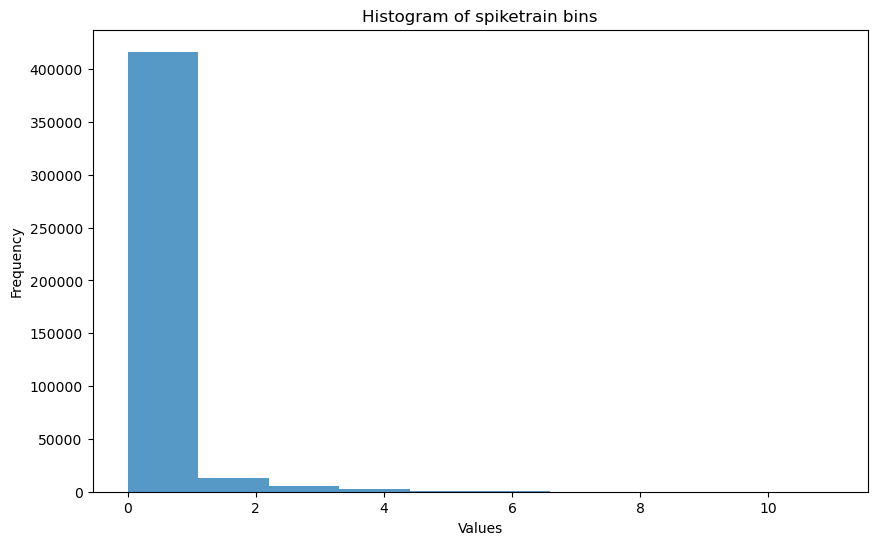

In [43]:
combined_spiketrains_100_s = df3.values.flatten()

# Plot a histogram of the combined values
plt.figure(figsize=(10, 6))
plt.hist(combined_spiketrains_100_s, alpha=0.75)
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.title('Histogram of spiketrain bins')
# Set the x-axis limit
#plt.xlim(0, 50)
plt.show()

In [45]:
combined_spiketrains_100_s

array([1, 0, 0, ..., 0, 0, 0], dtype=int64)

In [46]:
len(combined_spiketrains_100_s)

437749

In [48]:
unique, counts = np.unique(combined_spiketrains_100_s, return_counts=True)

print(np.asarray((unique, counts)).T)

[[     0 372360]
 [     1  44063]
 [     2  12748]
 [     3   5136]
 [     4   2140]
 [     5    806]
 [     6    331]
 [     7    104]
 [     8     50]
 [     9      7]
 [    10      3]
 [    11      1]]


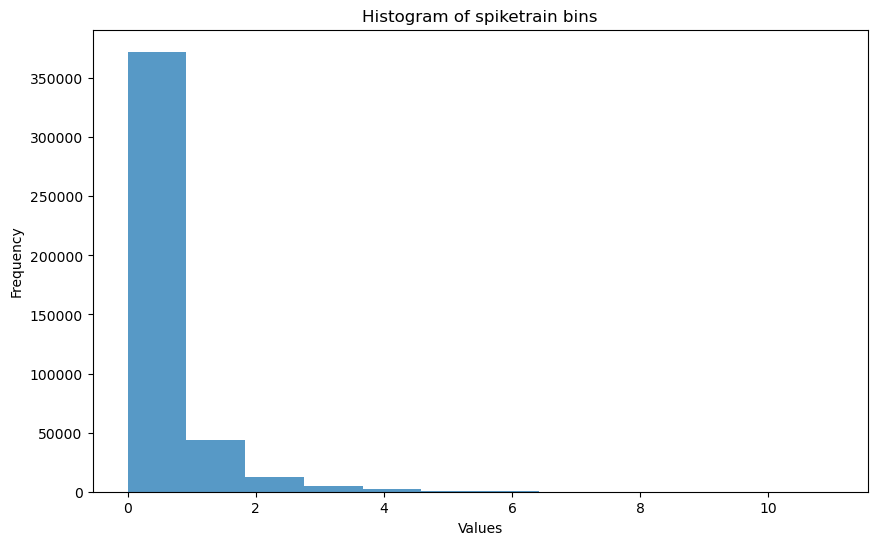

In [49]:
combined_spiketrains_100_s = df3.values.flatten()

# Plot a histogram of the combined values
plt.figure(figsize=(10, 6))
plt.hist(combined_spiketrains_100_s, bins=12, alpha=0.75)
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.title('Histogram of spiketrain bins')
# Set the x-axis limit
#plt.xlim(0, 50)
plt.show()

In [56]:
spike_analysis = spike.SpikeAnalysis_MultiRecording(ephys_data, timebin=5, smoothing_window=300, ignore_freq=0.5)

All set to analyze


In [57]:
recordings = spike_analysis.ephyscollection.collection

recording_name1 = '20230622_110832_standard_comp_to_both_rewarded_D1_subj_1-1_t1b3L_box1_merged.rec'
recording1 = recordings.get(recording_name1)

recording_name2 = '20230622_110832_standard_comp_to_both_rewarded_D1_subj_1-2_t3b3L_box1_merged.rec'
recording2 = recordings.get(recording_name2)

In [58]:
df2 = pd.DataFrame.from_dict(recording1.unit_spiketrains, orient='index')
df3= df2.transpose()
df3

,9,24,76,10,94,87,1,15,97,39,2,11,77
0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
673471,0,0,0,0,0,0,0,0,0,0,0,0,0
673472,0,0,0,0,0,0,0,0,0,0,0,0,0
673473,0,0,0,0,0,0,0,0,0,0,0,0,0
673474,0,0,0,0,0,0,0,0,0,0,0,0,0


In [59]:
combined_spiketrains_5 = df3.values.flatten()

In [60]:
combined_spiketrains_5

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

In [61]:
unique, counts = np.unique(combined_spiketrains_5, return_counts=True)

print(np.asarray((unique, counts)).T)

[[      0 8654596]
 [      1  100409]
 [      2     183]]


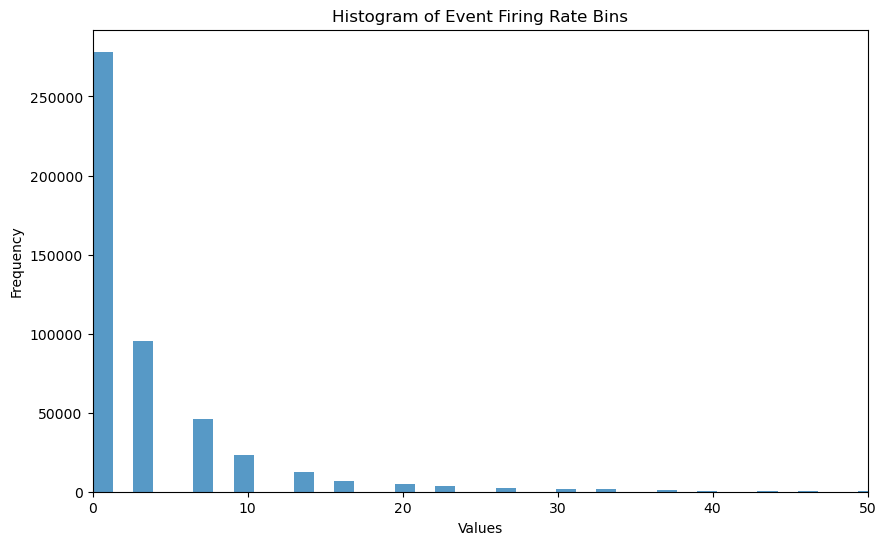

In [64]:
combined_values = event_spikes[event_cols].values.flatten()

# Plot a histogram of the combined values
plt.figure(figsize=(10, 6))
plt.hist(combined_values, bins=100, alpha=0.75)
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.title('Histogram of Event Firing Rate Bins')

# Set the x-axis limit
plt.xlim(0, 50)

plt.show()

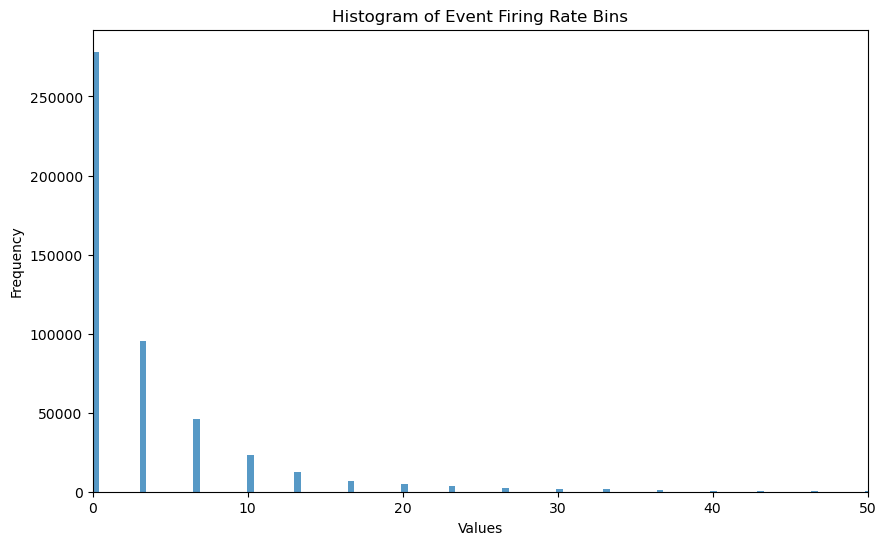

In [66]:
plt.figure(figsize=(10, 6))
plt.hist(combined_values, bins=300, alpha=0.75)
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.title('Histogram of Event Firing Rate Bins')

# Set the x-axis limit
plt.xlim(0, 50)

plt.show()

In [67]:
combined_values2 = combined_values<15

In [68]:
len(combined_values)

480100

In [69]:
len(combined_values2)

480100

In [71]:
type(combined_values)

numpy.ndarray

In [72]:
unique, counts = np.unique(combined_values, return_counts=True)

print(np.asarray((unique, counts)).T)

[[0.00000000e+00 2.78312000e+05]
 [3.33333333e+00 9.53970000e+04]
 [6.66666667e+00 4.58190000e+04]
 [1.00000000e+01 2.34680000e+04]
 [1.33333333e+01 1.24590000e+04]
 [1.66666667e+01 7.03300000e+03]
 [2.00000000e+01 1.32400000e+03]
 [2.00000000e+01 3.24600000e+03]
 [2.33333333e+01 1.36100000e+03]
 [2.33333333e+01 1.95800000e+03]
 [2.66666667e+01 1.23000000e+02]
 [2.66666667e+01 2.38800000e+03]
 [3.00000000e+01 1.33000000e+02]
 [3.00000000e+01 9.29000000e+02]
 [3.00000000e+01 8.17000000e+02]
 [3.33333333e+01 1.40600000e+03]
 [3.33333333e+01 5.70000000e+01]
 [3.66666667e+01 1.29000000e+02]
 [3.66666667e+01 9.30000000e+02]
 [4.00000000e+01 1.38000000e+02]
 [4.00000000e+01 6.00000000e+02]
 [4.33333333e+01 5.52000000e+02]
 [4.33333333e+01 2.00000000e+01]
 [4.66666667e+01 1.56000000e+02]
 [4.66666667e+01 2.54000000e+02]
 [5.00000000e+01 9.50000000e+01]
 [5.00000000e+01 1.96000000e+02]
 [5.33333333e+01 2.00000000e+00]
 [5.33333333e+01 2.05000000e+02]
 [5.33333333e+01 2.00000000e+00]
 [5.666666

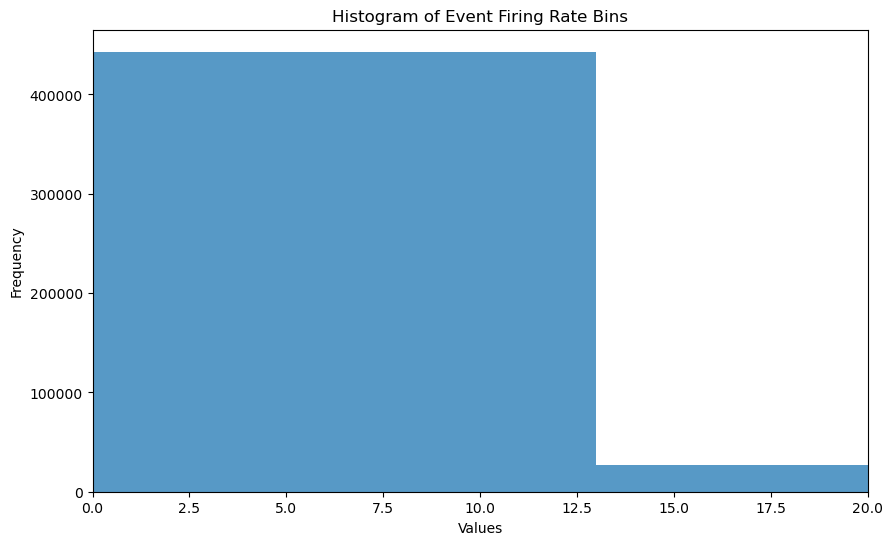

In [73]:
combined_values = event_spikes[event_cols].values.flatten()

# Plot a histogram of the combined values
plt.figure(figsize=(10, 6))
plt.hist(combined_values, alpha=0.75)
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.title('Histogram of Event Firing Rate Bins')

# Set the x-axis limit
plt.xlim(0, 20)

plt.show()

In [74]:
spike_analysis = spike.SpikeAnalysis_MultiRecording(ephys_data, timebin=100, smoothing_window=300, ignore_freq=0.5)

event_spikes = spike_analysis.generate_event_dataframe()

event_spikes['Pre-event timebin 1'].value_counts()

All set to analyze


Pre-event timebin 1
0.000000      2747
3.333333       906
6.666667       492
10.000000      241
13.333333      139
16.666667       81
20.000000       42
26.666667       24
23.333333       21
36.666667       18
23.333333       15
20.000000       13
33.333333       11
30.000000        9
30.000000        8
40.000000        6
46.666667        5
50.000000        4
76.666667        4
46.666667        2
60.000000        2
53.333333        2
60.000000        2
26.666667        1
146.666667       1
66.666667        1
63.333333        1
43.333333        1
56.666667        1
50.000000        1
Name: count, dtype: int64

In [75]:
spike_analysis = spike.SpikeAnalysis_MultiRecording(ephys_data, timebin=5, smoothing_window=300, ignore_freq=0.5)

event_spikes = spike_analysis.generate_event_dataframe()

event_spikes['Pre-event timebin 1'].value_counts()

All set to analyze


Pre-event timebin 1
0.000000      2747
3.333333       906
6.666667       491
10.000000      242
13.333333      132
16.666667       87
20.000000       55
23.333333       28
26.666667       26
30.000000       14
36.666667       12
43.333333        8
40.000000        8
33.333333        8
50.000000        7
46.666667        7
80.000000        3
23.333333        3
36.666667        2
33.333333        2
56.666667        2
30.000000        2
43.333333        1
53.333333        1
126.666667       1
70.000000        1
66.666667        1
73.333333        1
60.000000        1
56.666667        1
53.333333        1
Name: count, dtype: int64

In [76]:
def get_firing_rate(spiketrain, smoothing_window, timebin):
    """
    calculates firing rate (spikes/second)

    Args (3 total, 1 required):
        spiketrain: numpy array, in timebin (ms) bins
        smoothing_window: int, default=250, smoothing average window (ms)
        timebin: int, default = 1, timebin (ms) of spiketrain

    Return (1):
        firing_rate: numpy array of firing rates in timebin sized windows

    """
    smoothing_bins = int(smoothing_window / timebin)
    weights = np.ones(smoothing_bins) / smoothing_bins * 1000 / timebin
    firing_rate = np.convolve(spiketrain, weights, mode="same")

    return firing_rate

recordings = spike_analysis.ephyscollection.collection

recording_name1 = '20230622_110832_standard_comp_to_both_rewarded_D1_subj_1-1_t1b3L_box1_merged.rec'
recording1 = recordings.get(recording_name1)

recording1.unit_spiketrains

{9: array([0, 0, 1, ..., 0, 0, 0], dtype=int64),
 24: array([0, 0, 0, ..., 0, 0, 0], dtype=int64),
 76: array([0, 0, 0, ..., 0, 0, 0], dtype=int64),
 10: array([0, 0, 0, ..., 0, 0, 0], dtype=int64),
 94: array([0, 0, 0, ..., 0, 0, 0], dtype=int64),
 87: array([0, 0, 0, ..., 0, 0, 0], dtype=int64),
 1: array([0, 0, 0, ..., 0, 0, 0], dtype=int64),
 15: array([0, 0, 0, ..., 0, 0, 0], dtype=int64),
 97: array([0, 0, 0, ..., 0, 0, 0], dtype=int64),
 39: array([0, 0, 0, ..., 0, 0, 0], dtype=int64),
 2: array([0, 0, 0, ..., 0, 0, 0], dtype=int64),
 11: array([0, 0, 0, ..., 0, 0, 0], dtype=int64),
 77: array([0, 0, 0, ..., 0, 0, 0], dtype=int64)}

In [78]:
firingrate9 = get_firing_rate(recording1.unit_spiketrains[9], 300, 5)

In [79]:
firingrate9

array([3.33333333, 3.33333333, 3.33333333, ..., 0.        , 0.        ,
       0.        ])

In [80]:
len(recording1.unit_spiketrains[9])

673476

In [81]:
len(firingrate9)

673476

In [82]:
spike_analysis = spike.SpikeAnalysis_MultiRecording(ephys_data, timebin=100, smoothing_window=300, ignore_freq=0.5)

event_spikes = spike_analysis.generate_event_dataframe()

event_spikes['Pre-event timebin 1'].value_counts()

All set to analyze


Pre-event timebin 1
0.000000      2747
3.333333       906
6.666667       492
10.000000      241
13.333333      139
16.666667       81
20.000000       42
26.666667       24
23.333333       21
36.666667       18
23.333333       15
20.000000       13
33.333333       11
30.000000        9
30.000000        8
40.000000        6
46.666667        5
50.000000        4
76.666667        4
46.666667        2
60.000000        2
53.333333        2
60.000000        2
26.666667        1
146.666667       1
66.666667        1
63.333333        1
43.333333        1
56.666667        1
50.000000        1
Name: count, dtype: int64

In [83]:
recordings = spike_analysis.ephyscollection.collection

recording_name1 = '20230622_110832_standard_comp_to_both_rewarded_D1_subj_1-1_t1b3L_box1_merged.rec'
recording1 = recordings.get(recording_name1)

firing_rate9 = get_firing_rate(recording1.unit_spiketrains[9], 300, 100)

In [84]:
len(recording1.unit_spiketrains[9])

33673

In [85]:
len(firing_rate9)

33673

In [86]:
firing_rate9

array([6.66666667, 6.66666667, 3.33333333, ..., 0.        , 0.        ,
       0.        ])

In [87]:
recording1.unit_spiketrains[9][:12]

array([1, 1, 0, 0, 0, 0, 2, 0, 1, 0, 0, 0], dtype=int64)

In [88]:
firing_rate9[:12]

array([ 6.66666667,  6.66666667,  3.33333333,  0.        ,  0.        ,
        6.66666667,  6.66666667, 10.        ,  3.33333333,  3.33333333,
        0.        ,  0.        ])

non_smoothed_fr = np.array([10, 10, 0, 0, 0, 0, 20, 0, 10, 0, 0, 0])\
smoothed_fr = np.array([?, 6.67, 3.33, 0, ...])

In [89]:
spike_analysis = spike.SpikeAnalysis_MultiRecording(ephys_data, timebin=5, smoothing_window=100, ignore_freq=0.5)

event_spikes = spike_analysis.generate_event_dataframe()

event_spikes['Pre-event timebin 1'].value_counts()

All set to analyze


Pre-event timebin 1
0.0      3611
10.0      823
20.0      227
30.0       75
40.0       30
50.0       15
60.0        8
70.0        7
120.0       2
80.0        2
90.0        1
Name: count, dtype: int64

In [90]:
spike_analysis = spike.SpikeAnalysis_MultiRecording(ephys_data, timebin=5, smoothing_window=50, ignore_freq=0.5)

event_spikes = spike_analysis.generate_event_dataframe()

event_spikes['Pre-event timebin 1'].value_counts()

All set to analyze


Pre-event timebin 1
0.0      4071
20.0      594
40.0       96
60.0       31
80.0        5
100.0       3
120.0       1
Name: count, dtype: int64

In [108]:
spike_analysis = spike.SpikeAnalysis_MultiRecording(ephys_data, timebin=5, smoothing_window=250, ignore_freq=0.5)

event_spikes = spike_analysis.generate_event_dataframe()

event_spikes['Pre-event timebin 1'].value_counts()

All set to analyze


Pre-event timebin 1
0.0      2911
4.0       905
8.0       465
12.0      190
16.0      129
20.0       62
24.0       34
28.0       25
32.0       22
36.0       14
40.0       13
48.0        6
52.0        6
44.0        5
56.0        4
60.0        3
80.0        1
136.0       1
84.0        1
64.0        1
76.0        1
96.0        1
92.0        1
Name: count, dtype: int64

In [109]:
event_spikes

,Recording,Event name,Event number,Unit number,Pre-event timebin 1,Pre-event timebin 2,Pre-event timebin 3,Pre-event timebin 4,Pre-event timebin 5,Pre-event timebin 6,...,Event timebin 1991,Event timebin 1992,Event timebin 1993,Event timebin 1994,Event timebin 1995,Event timebin 1996,Event timebin 1997,Event timebin 1998,Event timebin 1999,Event timebin 2000
0,20230622_110832_standard_comp_to_both_rewarded...,lose,1,9,8.0,8.0,8.0,8.0,8.0,4.0,...,16.0,20.0,20.0,20.0,16.0,16.0,20.0,20.0,20.0,20.0
1,20230622_110832_standard_comp_to_both_rewarded...,lose,2,9,8.0,8.0,8.0,8.0,8.0,8.0,...,12.0,12.0,12.0,12.0,12.0,16.0,16.0,16.0,16.0,16.0
2,20230622_110832_standard_comp_to_both_rewarded...,lose,3,9,8.0,8.0,8.0,8.0,8.0,8.0,...,12.0,12.0,12.0,12.0,12.0,12.0,12.0,12.0,12.0,12.0
3,20230622_110832_standard_comp_to_both_rewarded...,lose,4,9,12.0,12.0,12.0,12.0,12.0,8.0,...,4.0,8.0,8.0,8.0,8.0,8.0,8.0,8.0,12.0,12.0
4,20230622_110832_standard_comp_to_both_rewarded...,lose,5,9,8.0,8.0,8.0,8.0,8.0,8.0,...,16.0,16.0,16.0,16.0,16.0,16.0,16.0,12.0,12.0,12.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4796,20230625_112913_standard_comp_to_both_rewarded...,both_rewarded,16,11,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4797,20230625_112913_standard_comp_to_both_rewarded...,both_rewarded,17,11,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4798,20230625_112913_standard_comp_to_both_rewarded...,both_rewarded,18,11,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4799,20230625_112913_standard_comp_to_both_rewarded...,both_rewarded,19,11,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [110]:
spike_analysis = spike.SpikeAnalysis_MultiRecording(ephys_data, timebin=100, smoothing_window=300, ignore_freq=0.5)

event_spikes = spike_analysis.generate_event_dataframe()

event_spikes

All set to analyze


,Recording,Event name,Event number,Unit number,Pre-event timebin 1,Pre-event timebin 2,Pre-event timebin 3,Pre-event timebin 4,Pre-event timebin 5,Pre-event timebin 6,...,Event timebin 91,Event timebin 92,Event timebin 93,Event timebin 94,Event timebin 95,Event timebin 96,Event timebin 97,Event timebin 98,Event timebin 99,Event timebin 100
0,20230622_110832_standard_comp_to_both_rewarded...,lose,1,9,10.000000,10.000000,10.000000,3.333333,6.666667,10.000000,...,16.666667,10.000000,6.666667,3.333333,6.666667,13.333333,10.000000,10.000000,10.000000,20.000000
1,20230622_110832_standard_comp_to_both_rewarded...,lose,2,9,6.666667,6.666667,16.666667,16.666667,23.333333,23.333333,...,6.666667,16.666667,20.000000,16.666667,10.000000,6.666667,6.666667,6.666667,10.000000,13.333333
2,20230622_110832_standard_comp_to_both_rewarded...,lose,3,9,10.000000,10.000000,20.000000,23.333333,23.333333,13.333333,...,20.000000,20.000000,6.666667,3.333333,10.000000,16.666667,23.333333,13.333333,10.000000,10.000000
3,20230622_110832_standard_comp_to_both_rewarded...,lose,4,9,10.000000,3.333333,6.666667,6.666667,16.666667,26.666667,...,6.666667,10.000000,10.000000,10.000000,13.333333,16.666667,16.666667,10.000000,3.333333,10.000000
4,20230622_110832_standard_comp_to_both_rewarded...,lose,5,9,13.333333,20.000000,23.333333,23.333333,36.666667,33.333333,...,10.000000,13.333333,16.666667,13.333333,13.333333,23.333333,23.333333,26.666667,13.333333,13.333333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4796,20230625_112913_standard_comp_to_both_rewarded...,both_rewarded,16,11,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4797,20230625_112913_standard_comp_to_both_rewarded...,both_rewarded,17,11,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4798,20230625_112913_standard_comp_to_both_rewarded...,both_rewarded,18,11,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4799,20230625_112913_standard_comp_to_both_rewarded...,both_rewarded,19,11,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,3.333333,3.333333,3.333333,0.000000,0.000000


In [111]:
event_spikes['Pre-event timebin 1'].value_counts()

Pre-event timebin 1
0.000000      2747
3.333333       906
6.666667       492
10.000000      241
13.333333      139
16.666667       81
20.000000       42
26.666667       24
23.333333       21
36.666667       18
23.333333       15
20.000000       13
33.333333       11
30.000000        9
30.000000        8
40.000000        6
46.666667        5
50.000000        4
76.666667        4
46.666667        2
60.000000        2
53.333333        2
60.000000        2
26.666667        1
146.666667       1
66.666667        1
63.333333        1
43.333333        1
56.666667        1
50.000000        1
Name: count, dtype: int64

In [112]:
event_spikes['Pre-Event Avg Firing Rate'] = event_spikes[pre_event_cols].mean(axis=1)
event_spikes['Event Avg Firing Rate'] = event_spikes[event_cols].mean(axis=1)

# Create the new DataFrame with the desired columns
avg_fr = event_spikes[['Recording', 'Event name', 'Unit number', 'Pre-Event Avg Firing Rate', 'Event Avg Firing Rate']]

In [113]:
avg_fr

,Recording,Event name,Unit number,Pre-Event Avg Firing Rate,Event Avg Firing Rate
0,20230622_110832_standard_comp_to_both_rewarded...,lose,9,12.4,9.900000
1,20230622_110832_standard_comp_to_both_rewarded...,lose,9,14.5,16.000000
2,20230622_110832_standard_comp_to_both_rewarded...,lose,9,11.4,10.800000
3,20230622_110832_standard_comp_to_both_rewarded...,lose,9,11.6,8.266667
4,20230622_110832_standard_comp_to_both_rewarded...,lose,9,15.1,15.200000
...,...,...,...,...,...
4796,20230625_112913_standard_comp_to_both_rewarded...,both_rewarded,11,1.7,0.600000
4797,20230625_112913_standard_comp_to_both_rewarded...,both_rewarded,11,0.0,0.200000
4798,20230625_112913_standard_comp_to_both_rewarded...,both_rewarded,11,0.2,0.100000
4799,20230625_112913_standard_comp_to_both_rewarded...,both_rewarded,11,0.1,0.300000


In [114]:
grouped_df = event_spikes.groupby(['Recording', 'Event name', 'Unit number'])[['Pre-Event Avg Firing Rate', 'Event Avg Firing Rate']].mean().reset_index()

In [115]:
grouped_df

,Recording,Event name,Unit number,Pre-Event Avg Firing Rate,Event Avg Firing Rate
0,20230622_110832_standard_comp_to_both_rewarded...,both_rewarded,1,0.625490,0.717647
1,20230622_110832_standard_comp_to_both_rewarded...,both_rewarded,2,3.996078,3.801961
2,20230622_110832_standard_comp_to_both_rewarded...,both_rewarded,9,15.637255,15.839216
3,20230622_110832_standard_comp_to_both_rewarded...,both_rewarded,10,2.688235,1.868627
4,20230622_110832_standard_comp_to_both_rewarded...,both_rewarded,11,3.660784,2.792157
...,...,...,...,...,...
268,20230625_112913_standard_comp_to_both_rewarded...,win,60,0.150000,2.033333
269,20230625_112913_standard_comp_to_both_rewarded...,win,77,0.991667,1.250000
270,20230625_112913_standard_comp_to_both_rewarded...,win,85,0.466667,1.033333
271,20230625_112913_standard_comp_to_both_rewarded...,win,99,0.916667,0.950000


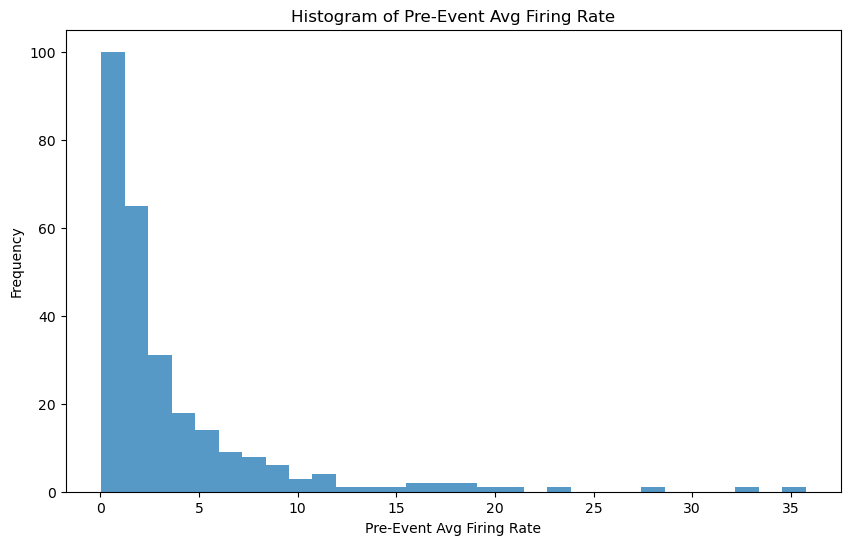

In [116]:
plt.figure(figsize=(10, 6))
plt.hist(grouped_df['Pre-Event Avg Firing Rate'], bins=30, alpha=0.75)
plt.xlabel('Pre-Event Avg Firing Rate')
plt.ylabel('Frequency')
plt.title('Histogram of Pre-Event Avg Firing Rate')
plt.show()

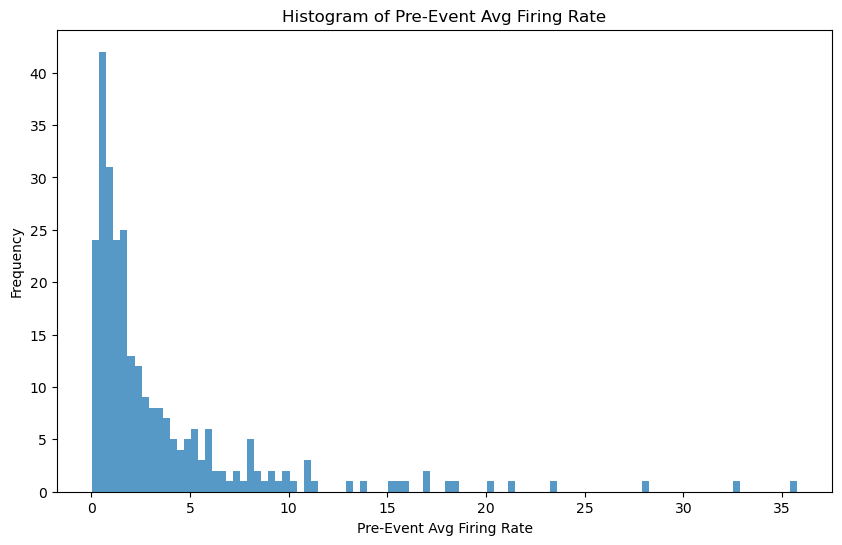

In [117]:
plt.figure(figsize=(10, 6))
plt.hist(grouped_df['Pre-Event Avg Firing Rate'], bins=100, alpha=0.75)
plt.xlabel('Pre-Event Avg Firing Rate')
plt.ylabel('Frequency')
plt.title('Histogram of Pre-Event Avg Firing Rate')
plt.show()

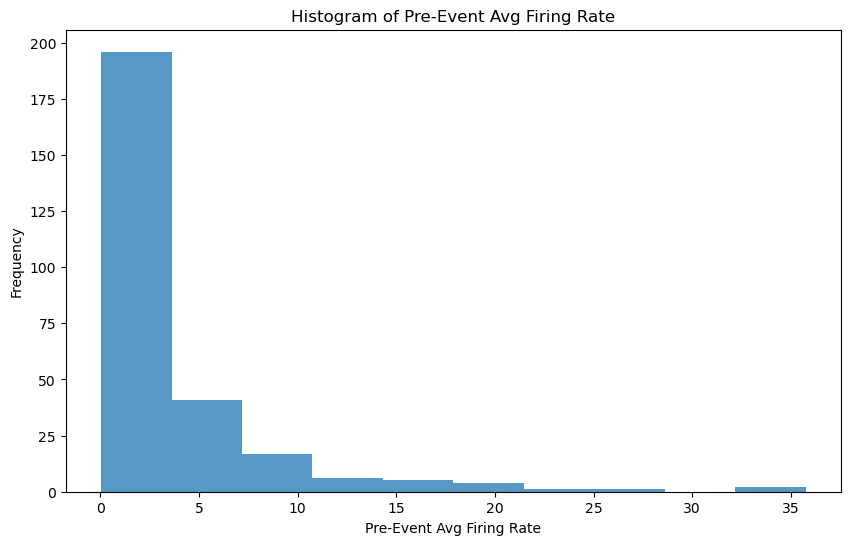

In [118]:
plt.figure(figsize=(10, 6))
plt.hist(grouped_df['Pre-Event Avg Firing Rate'], alpha=0.75)
plt.xlabel('Pre-Event Avg Firing Rate')
plt.ylabel('Frequency')
plt.title('Histogram of Pre-Event Avg Firing Rate')
plt.show()

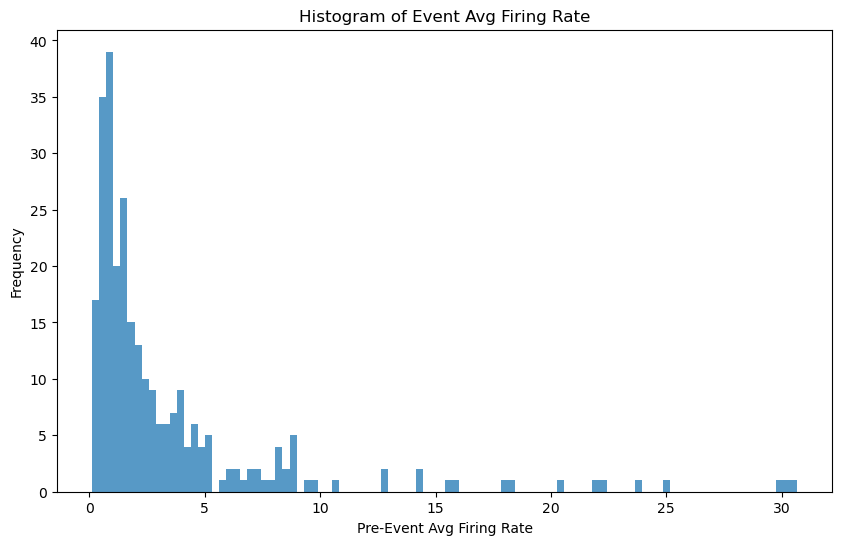

In [119]:
plt.figure(figsize=(10, 6))
plt.hist(grouped_df['Event Avg Firing Rate'], bins=100, alpha=0.75)
plt.xlabel('Pre-Event Avg Firing Rate')
plt.ylabel('Frequency')
plt.title('Histogram of Event Avg Firing Rate')
plt.show()

In [121]:
import scipy.stats as stats

stat, p_value = stats.shapiro(grouped_df['Pre-Event Avg Firing Rate'])

print(f'Statistic: {stat}')
print(f'P-value: {p_value}')

if p_value > 0.05:
    print("The data is normally distributed (fail to reject H0)")
else:
    print("The data is not normally distributed (reject H0)")

Statistic: 0.6229205131530762
P-value: 4.4061025167300815e-24
The data is not normally distributed (reject H0)


In [122]:
stat, p_value = stats.shapiro(grouped_df['Event Avg Firing Rate'])

print(f'Statistic: {stat}')
print(f'P-value: {p_value}')

if p_value > 0.05:
    print("The data is normally distributed (fail to reject H0)")
else:
    print("The data is not normally distributed (reject H0)")

Statistic: 0.5957766771316528
P-value: 8.361422696515647e-25
The data is not normally distributed (reject H0)
